In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from pinns.prelude import *
from pinns.domain import Hypercube
from pinns.calc import laplace, divergence
from scipy.stats.qmc import Sobol
from pinns.model import mlp
from pinns.opt import train_nn
from pinns.integrate import integrate, midpoint, gauss2
from pinns.interpolate import shape_function
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [3]:
a = 1.
b = 1.
c = 1.
domain = Hypercube((-a / 2, -b / 2, -c / 2), (a / 2, b / 2, c / 2))
x_dom = array(Sobol(3, seed=0).random_base2(12))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(9))
x_bnd = domain.transform_bnd(x_bnd)

In [4]:
# TODO:
# find constants A, K1, Ms
# train init mag  # ok
# stray field solver  # ok
# compute Ha, Hex
# minimize energy

In [63]:
_x_bnd = array(Sobol(2, seed=1).random_base2(8))
_x_bnd = domain.transform_bnd(_x_bnd)
x1 = [_x_bnd[_x_bnd[:, i] == -0.5, :] for i in range(3)]
x2 = [_x_bnd[_x_bnd[:, i] == 0.5, :] for i in range(3)]
l = shape_function(x1, x2)

In [64]:
weights = array(Sobol(4, seed=12345).random_base2(8))
W_elm = (weights[:, :3] * 2 - 1) * 8
b_elm = (weights[:, 3] * 2 - 1) * 8


def unit_vec(x):
    return x / norm(x, axis=-1, keepdims=True)

def m_init_vortex(x):
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = 0.14
    r = sqrt(x ** 2 + y ** 2)
    k = r**2 / rc**2
    # mx = - y / r * sqrt(1 - exp(-4*k))
    # my = x / r * sqrt(1 - exp(-4*k))
    # mz = exp(-2*k)
    
    mx = exp(-2*k)
    my = - z / r * sqrt(1 - exp(-4*k))
    mz = y / r * sqrt(1 - exp(-4*k))
    
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)


def m_init_flower(x):
    mx = 1 / a * x[..., 0] * x[..., 2]
    my = 1 / c * x[..., 1] * x[..., 2] + 1 / b ** 3 * x[..., 1] ** 3 * x[..., 2] ** 3
    mz = ones_like(my)
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)
# def m_init_flower(pos):
#     x, y, z = pos[..., 0], pos[..., 1], pos[..., 2]
#     mx = 0.
#     my = z
#     mz = y
#     norm_squared = mx**2 + my**2 + mz**2
#     # return lax.cond(
#     #     norm_squared <= 0.05,
#     #     lambda: array((1, 0, 0.)),
#     #     lambda: unit_vec(array((mx, my, mz)))
#     # )
#     m1 = zeros_like(pos).at[..., 0].set(1.)
#     m2 = unit_vec(array((mx, my, mz)))
#     return where(
#         norm_squared <= 0.05,
#         m1,
#         m2
#     )
    
# Function for initialising the vortex state.
# def m_init_vortex(pos):
#     x, y, z = pos[..., 0], pos[..., 1], pos[..., 2]
#     mx = zeros_like(x)
#     my = sin(pi/2 * x)
#     mz = cos(pi/2 * x)
#     return unit_vec(stack([mx, my, mz], axis=-1))


# m = m_init_vortex
#f = lambda x: -divergence(m)(x)
# def l(x):
#     return jnp.prod(1. - (abs(x) / 0.5) ** 2)

h = lambda x: tanh(W_elm @ x + b_elm)
u = lambda x: l(x) * h(x)

In [65]:
# train init mag
def cat2sph(x):
    x = unit_vec(x)
    theta1 = jnp.arctan2(x[..., 1], x[..., 0])
    theta2 = jnp.arccos(x[..., 2])
    return jnp.stack([theta1, theta2], axis=-1)

def sph2cat(theta):
    theta1 = theta[..., 0]
    theta2 = theta[..., 1]
    x = cos(theta1) * sin(theta2)
    y = sin(theta1) * sin(theta2)
    z = cos(theta2)
    return jnp.stack([x, y, z], axis=-1)

m0 = m_init_vortex(x_dom)
theta0 = cat2sph(m0)

# from pinns.elm import elm
# m_elm = elm(h, x_dom, theta0)


In [93]:

from pinns.opt import train_nn

key, subkey = random.split(random.PRNGKey(42), 2)
mag_model, params = mlp(subkey, [3, 40, 40, 40,  2])
tx = optax.adam(0.001)
init_state = TrainState.create(
    apply_fn=mag_model.apply, 
    params=params,
    tx=tx
)
def train_init_mag(theta_nn, state, m, key, epochs=500):
    theta0 = cat2sph(vmap(m)(x_dom))
    
    @jit
    def make_batches(rng):
        batches = 24
        batch_size_dom = x_dom.shape[0] // batches

        perms_dom = jax.random.permutation(rng, x_dom.shape[0])
        perms_dom = perms_dom[:batches * batch_size_dom]  # skip incomplete batch
        perms_dom = perms_dom.reshape((batches, batch_size_dom))

        return x_dom[perms_dom], theta0[perms_dom]
    
    @jit
    def loss(params, x, y):
        theta_pred = theta_nn.apply(params, x)
        l = mean(norm(theta_pred - y, axis=-1) ** 2)
        return l, {'loss': l}

    return train_nn(loss, state, make_batches, key, epochs=epochs)
    # params = state.params
    # _theta_nn = lambda x: theta_nn.apply(params, x)
    # return _theta_nn, hist

key, train_key = random.split(key)
mag_init_state, hist = train_init_mag(mag_model, init_state, m_init_flower, train_key)

In [94]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(hist['loss'])

In [95]:
_theta_nn = lambda x: mag_model.apply(mag_init_state.params, x)
theta_pred = vmap(_theta_nn)(x_dom)
mean(norm(sph2cat(theta_pred) - m0, axis=-1) ** 2)

DeviceArray(2.001178, dtype=float32)

In [96]:
# i = 2
# z1 = lambda x: m_vortex(x)[i]
# z2 = lambda x: sph2cat(theta_nn(x))[i]
# plot_model(vmap(z1))
# plot_model(vmap(z2))

In [97]:
from pinns.elm import elm

_x_bnd = array(Sobol(2, seed=123).random_base2(14))
_x_bnd = domain.transform_bnd(_x_bnd)


def phi2_solution(x, x_bnd, phi1, l, m):
    eps = 1e-10
    def g(y):
        n = unit_vec(-grad(l)(y))
        return dot(m(y), n) - dot(grad(phi1)(y), n)
    
    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)
    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return 6 / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)

def solve_stray_field(h_elm, l, m):
    u = lambda x: l(x) * h_elm(x)
    f = lambda x: -divergence(m)(x)
    A = vmap(lambda x: -laplace(u)(x))(x_dom)
    b1 = vmap(f)(x_dom)
    U, S, VT = jax.scipy.linalg.svd(A, full_matrices=False, lapack_driver="gesvd")
    params_phi1 = VT.T @ ((1 / S) * (U.T @ b1))
    phi1 = lambda x: u(x) @ params_phi1
    phi_bnd = phi2_solution(x_bnd, _x_bnd, phi1, l, m)
    g2 = elm(h, x_bnd, phi_bnd, ridge=0.)
    b2 = vmap(laplace(g2))(x_dom)
    params_phi2 = VT.T @ ((1 / S) * (U.T @ b2))
    phi2 = lambda x: u(x) @ params_phi2 + g2(x)
    phi_nn = lambda x: phi1(x) + phi2(x)
    return phi_nn

In [98]:
phi = solve_stray_field(h, l, m_init_flower)

In [99]:

def ed(model, x):
    Ms = 1.
    H = lambda x: -grad(model)(x)
    e = lambda x: dot(m(x), H(x)) 
    return -Ms * (a * b * c) / 2 * jnp.sum(vmap(e)(x)) / len(x)

print(f"{2.189e-02 - abs(ed(phi, x_dom)):.4e}")

-1.3308e-01


In [100]:
abs(ed(phi, x_dom))

DeviceArray(0.15497155, dtype=float32)

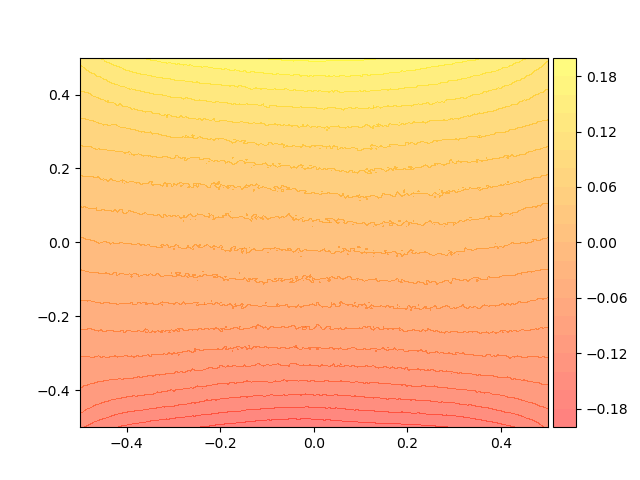

In [101]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_result(sol, ax):
    plt.sca(ax)
    N = 200
    x = np.linspace(-a/2, a/2, N)
    z = np.linspace(-c/2, c/2, N)

    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)


def plot_model(model, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        fig.subplots_adjust(wspace=0.4)
    plot_result(model, ax)

plot_model(vmap(phi))

In [102]:
Ms = 1.
lex = 1 / 8# 8.4375

mu0 = 4 * pi * 1e-7
Km = 1 / 2 * mu0 * Ms ** 2
A = lex ** 2 * Km
K1 = 0.1 * Km
# Km = 1e6
# lex = 8.
# Ms = sqrt(2 * Km / mu0)
# # A = 1 / 2 * mu0 * Ms ** 2 * 8 ** 2
# A = 8 ** 2
# K1 = 0.1 * Km

def Heff(m, phi, x):
    Hex = 2 * A / (mu0 * Ms) * laplace(m)(x)
    easy_axis = array([0., 0., 1.])
    Hani = - 2 * K1 * (m(x)[2]) * easy_axis / (mu0 * Ms)
    Hs = lambda x: -grad(phi)(x) * Ms
    return Hex + Hani + Hs(x)


@jit
def make_batches(rng):
    batches = 24
    batch_size_dom = x_dom.shape[0] // batches

    perms_dom = jax.random.permutation(rng, x_dom.shape[0])
    perms_dom = perms_dom[:batches * batch_size_dom]  # skip incomplete batch
    perms_dom = perms_dom.reshape((batches, batch_size_dom))

    return x_dom[perms_dom],


def loss(params, x):
    #_m = lambda x: sph2cat(mag_model.apply(lax.stop_gradient(params), x))
    m = lambda x: sph2cat(mag_model.apply(params, x))
    phi = solve_stray_field(h, l, m)
    # Heff_unit = unit_vec(vmap(Heff, (None, None, 0))(m, phi, x))
    def _loss(x):
        Heff_unit = unit_vec(Heff(m, phi, x))
        return 1 - dot(Heff_unit, m(x)) ** 2
        # _Heff = Heff(m, phi, x)
        # _m = m(x)
        # c = 1 / (_norm(_Heff) ** 2 * _norm(_m) ** 2)
        # return  1 - c * dot(_Heff, _m) ** 2
    
    _l = mean(vmap(_loss)(x))
    return _l, {'loss': _l}


init_state = TrainState.create(
    apply_fn=mag_model.apply, 
    params=params,
    tx=tx
)

key, train_key = random.split(key)
tx = optax.adam(0.0001)
init_state = TrainState.create(
    apply_fn=mag_model.apply, 
    params=mag_init_state.params,
    tx=tx
)
state, hist = train_nn(loss, mag_init_state, make_batches, train_key, epochs=200)

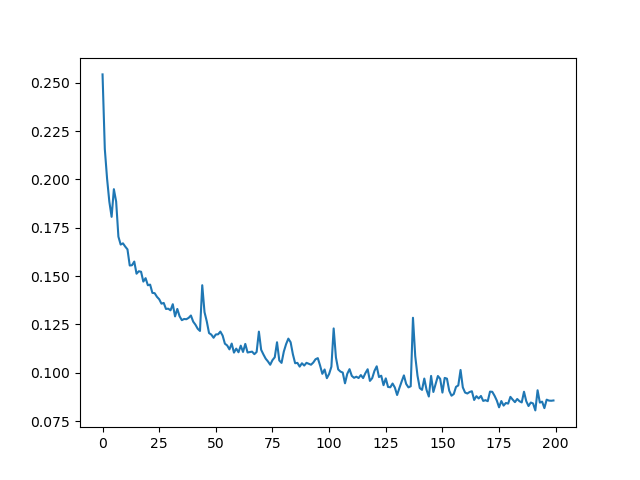

In [103]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(hist['loss'])
fig.savefig("loss.png")

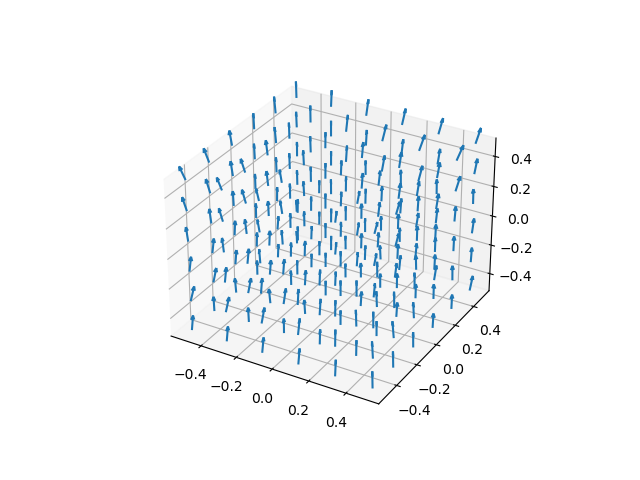

In [104]:
i = 0
# z2 = lambda x: sph2cat(mag_model.apply(state.params, x))[i]


ax = plt.figure().add_subplot(projection='3d')

# Make the grid
x, y, z = jnp.meshgrid(jnp.arange(-0.5, 0.51, 0.2),
                      jnp.arange(-0.5, 0.51, 0.2),
                      jnp.arange(-0.5, 0.51, 0.2))

X = jnp.stack([x, y, z], axis=-1)
_X = X.reshape(-1, 3)
mag = sph2cat(mag_model.apply(state.params, _X)).reshape(X.shape)
#mag = sph2cat(mag_model.apply(mag_init_state.params, _X)).reshape(X.shape)
#mag = m_init_flower(_X).reshape(X.shape)

ax.quiver(x, y, z, mag[..., 0], mag[..., 1], mag[..., 2], length=0.1, normalize=True)

plt.gcf().savefig("mag.png")
# plt.show()

In [21]:
mag.shape

(11, 11, 11, 3)